In [47]:
import pandas as pd
import numpy as np

import featuretools as ft
from datetime import datetime
from uuid import uuid4
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import xgboost as xgb

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [26]:
# https://github.com/IBM/telco-customer-churn-on-icp4d
URL_TO_DATA = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

CUSTOMERS = [
    # "customerID",
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "ContractStartDate",
]
SUBSCRIPTIONS = [
    # "customerID",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

BILLING = [
    # "customerID",
    "tenure",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "MonthlyCharges",
    "TotalCharges",
    "Churn",
]

BACK_COUNT_DATE = datetime.fromisoformat("2022-01-01")
TEST_SIZE = 0.2
VALID_SIZE = 0.25
RANDOM_STATE = 42

- ft titanic https://www.kaggle.com/code/liananapalkova/automated-feature-engineering-for-titanic-dataset/notebook
- the dataset https://github.com/IBM/telco-customer-churn-on-icp4d/blob/master/data/Telco-Customer-Churn.csv
- titanic https://medium.com/dataexplorations/tool-review-can-featuretools-simplify-the-process-of-feature-engineering-5d165100b0c3
- time indexing recomandations https://stackoverflow.com/questions/49711987/how-do-i-prevent-data-leakage-with-featuretools




### Denormalize into 
- customer_df:      customer_id (PK), subscription_id (FK), gender, SeniorCitizen, Partner, Dependents, tenure, Churn
- services_df:      service_id (PK), service_name
- subscription_df:  subscription_id (PK), service_id, customer_id
- billing_df:       billing_id, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges


In [27]:
# in case of CERTIFICATE_VERIFY_FAILED run Install Certificates.command
# see also https://stackoverflow.com/questions/50236117/scraping-ssl-certificate-verify-failed-error-for-http-en-wikipedia-org
df = pd.read_csv(filepath_or_buffer=URL_TO_DATA, index_col=0)

In [50]:
# convert
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# generate syntatic time index
df["ContractStartDate"] = list(
    map(
        lambda tenure, dat=BACK_COUNT_DATE: dat - relativedelta(months=-tenure),
        df["tenure"],
    )
)
# df["customerID"] = df.index
df["billingId"] = [str(uuid4()) for _ in range(df.shape[0])]
df["subscriptionId"] = [str(uuid4()) for _ in range(df.shape[0])]

# convert to 1/0
df["Churn"] = np.where(df["Churn"] == 'Yes', 1, 0)

In [51]:
y = df["Churn"]
X = df.drop(columns=["Churn"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VALID_SIZE, random_state=RANDOM_STATE
)  # 0.25 x 0.8 = 0.2

In [20]:
# df_customers = df[CUSTOMERS].copy(deep=True)
# df_subscriptions = df[SUBSCRIPTIONS].copy(deep=True)
# df_billing = df[BILLING].copy(deep=True)

In [21]:
# dataframes = {
#     "customers": (df_customers, "customer_id"),
#     "subscriptions": (df_subscriptions, "customer_id", "customer_id"),
#     "billing": (df_billing, "customer_id", "customer_id"),
# }


# relationships = [
#     ("customers", "customer_id", "subscriptions", "customer_id"),
#     ("subscriptions", "customer_id", "billing", "customer_id"),
# ]

# feature_matrix_customers, features_defs = ft.dfs(
#     dataframes=dataframes,
#     relationships=relationships,
#     target_dataframe_name="customers",
# )
# feature_matrix_customers

In [22]:
# https://featuretools.alteryx.com/en/stable/generated/featuretools.EntitySet.add_dataframe.html#featuretools.EntitySet.add_dataframe
# entity_set = ft.EntitySet("customer_churn_entities")

# entity_set.add_dataframe(
#     dataframe_name="customers",
#     index="customerID",
#     time_index="ContractStartDate",
#     dataframe=df_customers,
# )

# entity_set.add_dataframe(
#     dataframe_name="subscriptions",
#     index="customerID",
#     dataframe=df_subscriptions,
# )

# entity_set.add_dataframe(
#     dataframe_name="billing",
#     index="customerID",
#     dataframe=df_billing,
# )

# relationships = [
#     ("customers", "customerID", "subscriptions", "customerID"),
#     ("subscriptions", "customerID", "billing", "customerID"),
# ]

# entity_set.add_relationships(relationships=relationships)

In [34]:
es = ft.EntitySet(id="customer_churn")

es.add_dataframe(
    dataframe_name="customers",
    index="customerID",
    time_index="ContractStartDate",
    dataframe=X_train,
)

es.normalize_dataframe(
    base_dataframe_name="customers",
    new_dataframe_name="subscriptions",
    index="subscriptionId",
)

es.normalize_dataframe(
    base_dataframe_name="customers", new_dataframe_name="billings", index="billingId"
)

/Users/tara/Library/Caches/pypoetry/virtualenvs/data-science-playbooks-BCpveUor-py3.10/lib/python3.10/site-packages/featuretools/entityset/entityset.py:1906: UserWarning: index customerID not found in dataframe, creating new integer column
  warnings.warn(


Entityset: customer_churn
  DataFrames:
    customers [Rows: 4225, Columns: 23]
    subscriptions [Rows: 4225, Columns: 2]
    billings [Rows: 4225, Columns: 2]
  Relationships:
    customers.subscriptionId -> subscriptions.subscriptionId
    customers.billingId -> billings.billingId

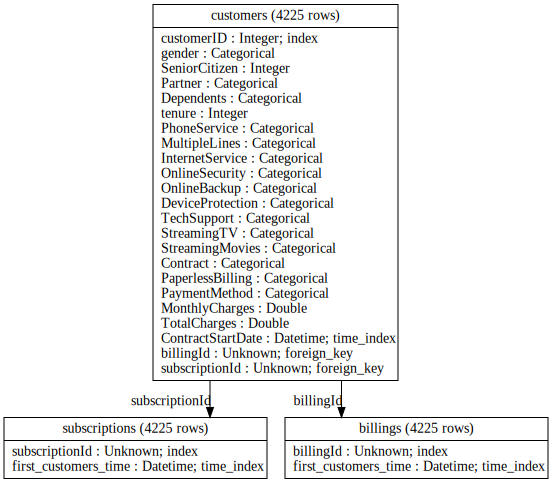

In [41]:
es.plot()

In [42]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es, target_dataframe_name="customers", max_depth=3
)




,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,subscriptions.NUM_UNIQUE(customers.WEEKDAY(ContractStartDate)),subscriptions.NUM_UNIQUE(customers.YEAR(ContractStartDate)),billings.MODE(customers.DAY(ContractStartDate)),billings.MODE(customers.MONTH(ContractStartDate)),billings.MODE(customers.WEEKDAY(ContractStartDate)),billings.MODE(customers.YEAR(ContractStartDate)),billings.NUM_UNIQUE(customers.DAY(ContractStartDate)),billings.NUM_UNIQUE(customers.MONTH(ContractStartDate)),billings.NUM_UNIQUE(customers.WEEKDAY(ContractStartDate)),billings.NUM_UNIQUE(customers.YEAR(ContractStartDate))
customerID,,,,,,,,,,,,,,,,,,,,,
1677,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,...,1,1,1,1,5,2022,1,1,1,1
1908,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,...,1,1,1,1,5,2022,1,1,1,1
1992,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,...,1,1,1,1,5,2022,1,1,1,1
2969,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,...,1,1,1,1,5,2022,1,1,1,1
3183,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,...,1,1,1,1,5,2022,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3962,Female,0,No,No,7,Yes,No,No,No internet service,No internet service,...,1,1,1,8,0,2022,1,1,1,1
3996,Male,0,No,No,7,Yes,Yes,Fiber optic,No,No,...,1,1,1,8,0,2022,1,1,1,1
4005,Female,0,No,No,7,Yes,Yes,Fiber optic,No,No,...,1,1,1,8,0,2022,1,1,1,1


In [44]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_defs)
feature_matrix_enc

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,subscriptions.COUNT(customers),subscriptions.MAX(customers.MonthlyCharges),subscriptions.MAX(customers.SeniorCitizen),subscriptions.MAX(customers.TotalCharges),subscriptions.MAX(customers.tenure),subscriptions.MEAN(customers.MonthlyCharges),...,billings.MODE(customers.MONTH(ContractStartDate)) is unknown,billings.MODE(customers.WEEKDAY(ContractStartDate)) = 1,billings.MODE(customers.WEEKDAY(ContractStartDate)) = 4,billings.MODE(customers.WEEKDAY(ContractStartDate)) = 6,billings.MODE(customers.WEEKDAY(ContractStartDate)) = 0,billings.MODE(customers.WEEKDAY(ContractStartDate)) = 2,billings.MODE(customers.WEEKDAY(ContractStartDate)) = 5,billings.MODE(customers.WEEKDAY(ContractStartDate)) is unknown,billings.MODE(customers.YEAR(ContractStartDate)) = 2022,billings.MODE(customers.YEAR(ContractStartDate)) is unknown
customerID,,,,,,,,,,,,,,,,,,,,,
1677,0,0,56.05,NaN,1,56.05,0.0,NaN,0.0,56.05,...,False,False,False,False,False,False,True,False,True,False
1908,0,0,25.75,NaN,1,25.75,0.0,NaN,0.0,25.75,...,False,False,False,False,False,False,True,False,True,False
1992,0,0,20.25,NaN,1,20.25,0.0,NaN,0.0,20.25,...,False,False,False,False,False,False,True,False,True,False
2969,0,0,25.35,NaN,1,25.35,0.0,NaN,0.0,25.35,...,False,False,False,False,False,False,True,False,True,False
3183,0,0,52.55,NaN,1,52.55,0.0,NaN,0.0,52.55,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3962,0,7,20.65,155.90,1,20.65,0.0,155.90,7.0,20.65,...,False,False,False,False,True,False,False,False,True,False
3996,0,7,95.00,655.50,1,95.00,0.0,655.50,7.0,95.00,...,False,False,False,False,True,False,False,False,True,False
4005,0,7,74.90,541.15,1,74.90,0.0,541.15,7.0,74.90,...,False,False,False,False,True,False,False,False,True,False


In [45]:
features_enc

[<Feature: gender = Male>,
 <Feature: gender = Female>,
 <Feature: gender is unknown>,
 <Feature: SeniorCitizen>,
 <Feature: Partner = No>,
 <Feature: Partner = Yes>,
 <Feature: Partner is unknown>,
 <Feature: Dependents = No>,
 <Feature: Dependents = Yes>,
 <Feature: Dependents is unknown>,
 <Feature: tenure>,
 <Feature: PhoneService = Yes>,
 <Feature: PhoneService = No>,
 <Feature: PhoneService is unknown>,
 <Feature: MultipleLines = No>,
 <Feature: MultipleLines = Yes>,
 <Feature: MultipleLines = No phone service>,
 <Feature: MultipleLines is unknown>,
 <Feature: InternetService = Fiber optic>,
 <Feature: InternetService = DSL>,
 <Feature: InternetService = No>,
 <Feature: InternetService is unknown>,
 <Feature: OnlineSecurity = No>,
 <Feature: OnlineSecurity = No internet service>,
 <Feature: OnlineSecurity = Yes>,
 <Feature: OnlineSecurity is unknown>,
 <Feature: OnlineBackup = No>,
 <Feature: OnlineBackup = No internet service>,
 <Feature: OnlineBackup = Yes>,
 <Feature: OnlineBa

In [53]:
#xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
#xgb_model.fit(X_test, y)

#y_pred = xgb_model.predict(X)

#print(confusion_matrix(y, y_pred))

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:gender, Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, ContractStartDate, billingId, subscriptionId

In [52]:
np.where(df["Churn"] == 'Yes', 1, 0)

array([0, 0, 0, ..., 0, 0, 0])